# KMeans Clustering Analysis

## Table of Contents
 - Introduction
 - Part I: Data
 - Part II: Clustering
 - Part III: Analysis
 - Part IV: Conclusion

## Introduction <br>

Mixed Martial Arts is one of the most technical sports in the world. It combines grappling elements of Jiu-Jitsu, the striking of Muay-Thai & Boxing, and the wrestling of Judo and Sambo. There are several more fighting styles but these are some of the most popular. Generally, most MMA fighters in the UFC have a background in one or two specific martial arts before making the jump to MMA. <br>

The question we are trying to answer is, can we build a clustering model to broadly determine if a fighter is a grappler, striker, wrestler, or an all around fighter? And if we can, what is this signifigance of each style relative to who is the winner of a MMA fight? <br>

To answer this question we will attempt to use the KMeans Clustering and a Logistic Regression in the Scikit-Learn package to see how well this algorithm will fit to our data.

## Data

The data we will be using is the webscraped fight data we collected that is hosted on the UFC website. Although we will be importing the cleaned version of the dataset, we need to make some adjustements to our data frame so we can calculate the average metrics we need for each fighter. <br>

With these adjustments we will be able to fit our clustering algorithm to our data. First, let us import our data and have a peak of what it looks like.

In [1]:
# Import packages
import pandas as pd
import os

path = os.getcwd()

In [2]:
# Since we are in the UFC folder we need to grab our data from the Data subfolder
df = pd.read_csv(f'{path}\\Data\\cleanedData.csv')
display(df.head())
print(df.shape)

,R_Fighter,R_KD,R_Sub. att,R_Rev.,R_Ctrl,B_Fighter,B_KD,B_Sub. att,B_Rev.,B_Ctrl,...,B_Body_Landed,B_Body_Attempted,B_Leg_Landed,B_Leg_Attempted,B_Distance_Landed,B_Distance_Attempted,B_Clinch_Landed,B_Clinch_Attempted,B_Ground_Landed,B_Ground_Attempted
0,Brian Ortega,0,0,0,2.40,Yair Rodriguez,0,0,0,0.00,...,0.0,0.0,5.0,5.0,21.0,44.0,1.0,1.0,1.0,1.0
1,Michelle Waterson-Gomez,0,0,0,1.13,Amanda Lemos,0,1,1,0.08,...,3.0,5.0,6.0,7.0,20.0,35.0,0.0,0.0,0.0,0.0
2,Li Jingliang,1,0,0,0.50,Muslim Salikhov,0,0,0,1.17,...,3.0,6.0,2.0,2.0,20.0,51.0,0.0,1.0,3.0,4.0
3,Matt Schnell,0,2,1,2.67,Sumudaerji,1,0,2,2.22,...,10.0,11.0,11.0,11.0,35.0,53.0,13.0,19.0,10.0,11.0
4,Shane Burgos,0,3,0,6.42,Charles Jourdain,0,0,0,2.13,...,36.0,37.0,5.0,6.0,68.0,133.0,41.0,51.0,4.0,4.0


(6690, 55)


As we discussed earlier, we can see that each row contains the fight data for both fighters. We essentially need to slice our columns in half and insert the data as their own row of information. One way we can do that is by iterating over each row and collecting data specific to each fighter. We can store our results into a new dataframe which we will call our Cluster dataframe. We know which data belongs to what fighter beacause each fighter is given a color code, either they are fighting in the red or blue corner. <br>

To keep it simple, we will only use total strikes, submission, and takedown attempts. We will also collect the data on who won the fight but that will be used in our analysis later. For reference, if the fighter won the fight we will label that as a 1 and a 0 otherwise.

In [3]:
from tqdm import tqdm # pip install tqdm (loading bar for iterations)
cluster = pd.DataFrame()

for i in tqdm(range(len(df))):
    #Gather the data from the red corner
    cluster.loc[i,'Fighter'] = df.loc[i,'R_Fighter']    # Name
    cluster.loc[i,'Total Strikes'] = float(df.loc[i,'R_Total str._Attempted'])    # Total stikes attempted
    cluster.loc[i,'TakeDowns'] = float(df.loc[i,'R_Td_Attempted'])    # Takedown attempts
    cluster.loc[i,'Submissions'] = float(df.loc[i,'R_Sub. att'])    # Submission attempts
    cluster.loc[i,'Winner'] = 1 if df.loc[i,'Winner']=='Red' else 0

    # Gather the data from the blue corner
    i += len(df)
    cluster.loc[i,'Fighter'] = df.loc[i-len(df),'B_Fighter']    # Name
    cluster.loc[i,'Total Strikes'] = float(df.loc[i-len(df),'B_Total str._Attempted'])    # Total stikes attempted
    cluster.loc[i,'TakeDowns'] = float(df.loc[i-len(df),'B_Td_Attempted'])    # Takedown attempts
    cluster.loc[i,'Submissions'] = float(df.loc[i-len(df),'B_Sub. att'])    # Submission attempts
    cluster.loc[i,'Winner'] = 1 if df.loc[i-len(df),'Winner']=='Blue' else 0

    i -= len(df)
    
cluster.reset_index(inplace=True,drop=True)

100%|██████████| 6690/6690 [00:14<00:00, 450.43it/s]


In [4]:
display(cluster.head())
print(cluster.shape)

,Fighter,Total Strikes,TakeDowns,Submissions,Winner
0,Brian Ortega,39.0,5.0,0.0,0.0
1,Yair Rodriguez,76.0,0.0,0.0,1.0
2,Michelle Waterson-Gomez,62.0,2.0,0.0,0.0
3,Amanda Lemos,35.0,0.0,1.0,1.0
4,Li Jingliang,91.0,2.0,0.0,1.0


(13380, 5)


In [5]:
# We can now groupby each fighter and calculate their career averages, we will store our results in a data frame called career
career = cluster.groupby('Fighter').mean().drop(columns='Winner')
display(career.head())
print(career.shape)

,Total Strikes,TakeDowns,Submissions
Fighter,,,
AJ Dobson,110.0,0.000000,0.000000
AJ Fletcher,124.0,6.000000,2.000000
Aalon Cruz,7.5,1.500000,0.000000
Aaron Brink,5.0,1.000000,0.000000
Aaron Phillips,144.0,0.333333,0.333333


(2263, 3)


## Clustering

Now that we have the necessary data we can begin normalizing our data so we can create the best model of our clustering algorithm. We will do this by importing Scikit-Learn and using Min-Max Scaling.

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

scaler = MinMaxScaler()
for column in career.columns:
    career[column] =  scaler.fit_transform(career[column].values.reshape(-1,1))

# Return normalized data frame
display(career.head())
print(career.shape)

,Total Strikes,TakeDowns,Submissions
Fighter,,,
AJ Dobson,0.277078,0.000000,0.000000
AJ Fletcher,0.312343,0.333333,0.444444
Aalon Cruz,0.018892,0.083333,0.000000
Aaron Brink,0.012594,0.055556,0.000000
Aaron Phillips,0.362720,0.018519,0.074074


(2263, 3)


Now that we can cluster our data, it is important to know how many clusters we are going to use. With our data we can assume that a fighter can have one of four styles; striker, grappler, wrestler, or all around mixed martial artist. However, that does not mean that is the optimal number of clusters. We will test our hypothesis by modeling our data using N number of clusters and iterating over that 20 times.

In [7]:
# Define the number of clusters and a list that will store our sum of squared errors metric
Ks, SSE = [_ for _ in range(2,22)], []

for K in tqdm(Ks):
    model = KMeans(n_clusters=K,random_state=67).fit(career)
    SSE.append(model.inertia_)

100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


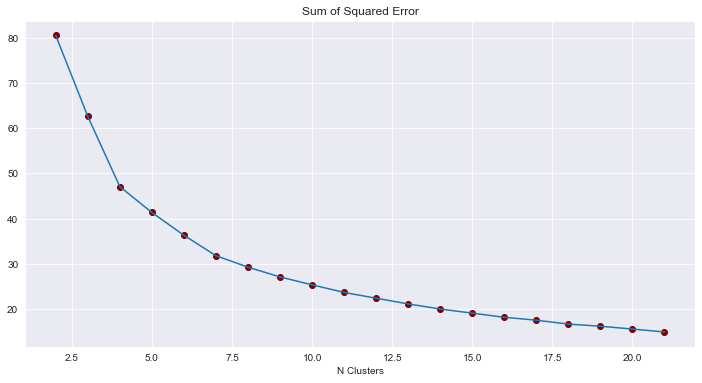

In [8]:
# Import packages
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

plt.figure(figsize=(12,6))
plt.scatter(Ks,SSE,color='maroon')
plt.plot(Ks,SSE)
plt.title('Sum of Squared Error')
plt.xlabel('N Clusters')
plt.show()

We should always expect of Sum of Squared Errors to decrease as our number of clusters increase. In theory every data point can be its own cluster and therefore the Sum of Squared Errors would be equal to zero. For our case, we can see that there is a kink in the graph at around the fourth N Cluster. Therefore the optimal number of clusters to have for our data should be four.

In [9]:
# Fit data into a 4Means models
model = KMeans(n_clusters=4,random_state=67).fit(career)
career['Cluster'] = model.labels_

career.groupby('Cluster').mean()

,Total Strikes,TakeDowns,Submissions
Cluster,,,
0,0.171795,0.136536,0.294715
1,0.267838,0.402307,0.082587
2,0.348991,0.120944,0.053016
3,0.128433,0.071857,0.031320


After grouping our data by cluster we can get an idea of what each cluster represents. Now, let us plot and analyze the results.

## Analysis

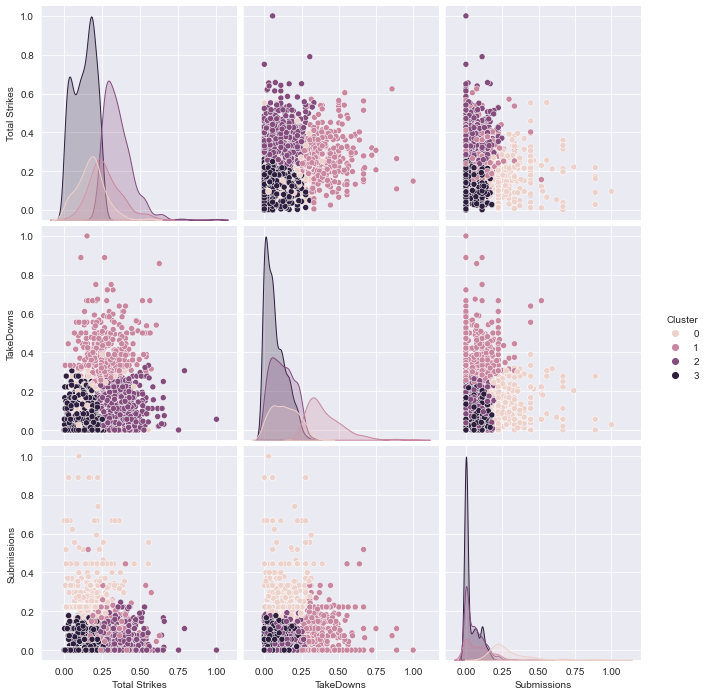

In [10]:
g = sns.pairplot(career,hue='Cluster')
g.fig.set_figheight(10)
# g.fig.set_width(20)
g.fig.set_figwidth(10)

Based on our scatterplot and ditribution matrix we can see how well our data has clustered. We can even make some assumptions on which clusters would be considered grapplers, strikers, wrestlers, or well rounded fighters. However, we can see some overlap in our clusters. If we plot our data in three dimensions we can better visualize our results and plot the centroids of our clusters.

In [11]:
# Import packages needed for 3d ploting
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.express as px
import plotly.graph_objs as go

init_notebook_mode(connected=True)
centroids = pd.DataFrame(model.cluster_centers_,columns=['X','Y','Z'])

plot_scatter = go.Scatter3d(x=career['Total Strikes'],y=career['TakeDowns'],z=career['Submissions'], mode='markers',
                            marker=dict(size=2.5,cmax=career['Cluster'].max(),cmin=career['Cluster'].min(),
                                color=career['Cluster'],colorbar=dict(title='Cluster'),colorscale='viridis',opacity=0.4))

plot_scatter2 = go.Scatter3d(x=centroids['X'],y=centroids['Y'],z=centroids['Z'], mode='markers',marker=dict(size=8,color='black'))

plotData = [plot_scatter,plot_scatter2]
layout = go.Layout(margin=dict(r=20,b=10,l=10,t=10))

fig = go.Figure(data=plotData,layout=layout)
fig.update_layout(scene=dict(
    xaxis_title='Total Strikes',
    yaxis_title='Takedowns',
    zaxis_title='Submissions',
))

iplot(fig,filename='3d Plot.html')

The above plot is a three dimensional render of our data while displaying our clusters by color. The black dots on the plot are the centroids for each cluster. <br>

Next we can map our clusters to each fighter in our clusters dataframe. We can see which fighting style has the highest winning percentage.

In [12]:
cluster['Cluster'] = cluster['Fighter'].map(dict(career['Cluster']))
display(cluster.head())
print(cluster.shape)

,Fighter,Total Strikes,TakeDowns,Submissions,Winner,Cluster
0,Brian Ortega,39.0,5.0,0.0,0.0,2
1,Yair Rodriguez,76.0,0.0,0.0,1.0,2
2,Michelle Waterson-Gomez,62.0,2.0,0.0,0.0,2
3,Amanda Lemos,35.0,0.0,1.0,1.0,3
4,Li Jingliang,91.0,2.0,0.0,1.0,2


(13380, 6)


In [13]:
cluster.groupby('Cluster').mean()

,Total Strikes,TakeDowns,Submissions,Winner
Cluster,,,,
0,73.183673,2.634308,1.148373,0.489796
1,112.068113,6.688937,0.437310,0.545770
2,135.788635,2.227684,0.280574,0.537357
3,61.312979,1.433190,0.206178,0.405172


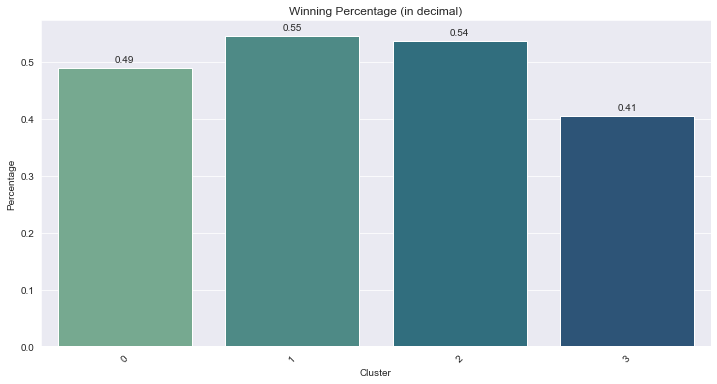

In [14]:
data = cluster.groupby('Cluster').mean()['Winner'].sort_values(ascending=False)

plt.figure(figsize=(12,6))
plots = sns.barplot(y=data,x=data.index,palette='crest')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='center', size=10, xytext=(0,8), textcoords='offset points')
plt.xticks(rotation=45)
plt.title('Winning Percentage (in decimal)')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
plt.show()

Based on the two cells above we can see the average attempts and winning percentage by cluster. In the dataframe provided above it should not be too suprising with the results we found. Such as, grapplers having the highest submission attempt average and wrestlers with the highest takedown attempt average. However, what is interesting is the winning percentage by cluster. Well rounded fighters have the lowest winning percentage, if we assume that each martial art is equally effective then we would see that each cluster would have a 50% winning accuracy. The average amongst all clusters is about 50% so we can assume that this assumption is to be true. <br>

Although we must ask ourselves, is there a reason to why well rounded fighters have such a low winning percentage compared to the rest of the styles? We can speculate with the following argument, being a master in a martial art is better than being a practitioner of all. As Bruce Lee once said, "I fear not the man who practiced 10,000 kicks once, but I fear the man who has practiced one kick 10,000 times." <br>

Lastly, let us fit a Logistic Regression to our data, not to see if we can predict the future winner of a fight, but to see if our variables, specifically style, has a signifigant effect on who won a MMA fight in the UFC historically.

In [15]:
# Import necessary packages
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score

In [16]:
ohe = OneHotEncoder(sparse=False)
encoded_cluster = pd.DataFrame(ohe.fit_transform(cluster[['Cluster']]),columns=ohe.categories_[0])

In [17]:
X = pd.concat([cluster.drop(columns=['Winner','Fighter','Cluster'],axis=1),encoded_cluster],axis=1)
y = cluster[['Winner']].values.reshape(len(cluster),)
scaler = StandardScaler()

for column in X.columns[:3]:
    X[column] = scaler.fit_transform(X[[column]])

display(X.head())
print(X.shape)

,Total Strikes,TakeDowns,Submissions,0,1,2,3
0,-0.788555,0.595765,-0.472013,0.0,0.0,1.0,0.0
1,-0.310054,-0.760320,-0.472013,0.0,0.0,1.0,0.0
2,-0.491108,-0.217886,-0.472013,0.0,0.0,1.0,0.0
3,-0.840285,-0.760320,0.702315,0.0,0.0,0.0,1.0
4,-0.116066,-0.217886,-0.472013,0.0,0.0,1.0,0.0


(13380, 7)


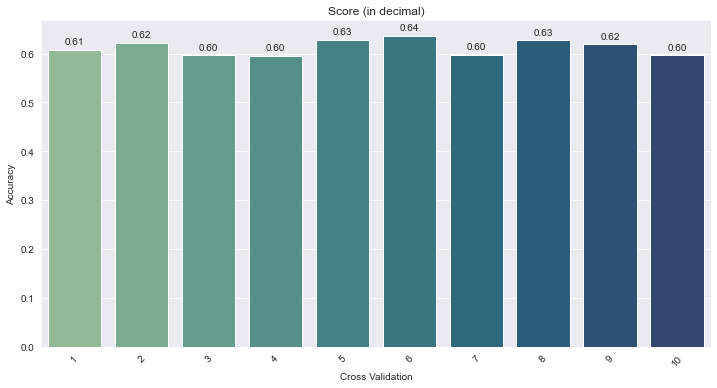

In [18]:
logreg = LogisticRegression(random_state=92)
data = cross_val_score(logreg,X=X,y=y,cv=10,scoring='accuracy')

plt.figure(figsize=(12,6))
plots = sns.barplot(y=data,x=[_ for _ in range(1,11)],palette='crest')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='center', size=10, xytext=(0,8), textcoords='offset points')
plt.xticks(rotation=45)
plt.title('Score (in decimal)')
plt.ylabel('Accuracy')
plt.xlabel('Cross Validation')
plt.show()

Now that we can assume that our model is not biased or has a lot of variance, we can model our data using statsmodels logistic regression to view our model summary.

In [19]:
logreg = sm.Logit(y,X).fit()
display(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.657319
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                13380
Model:                          Logit   Df Residuals:                    13373
Method:                           MLE   Df Model:                            6
Date:                Sun, 24 Jul 2022   Pseudo R-squ.:                 0.05147
Time:                        17:48:33   Log-Likelihood:                -8794.9
converged:                       True   LL-Null:                       -9272.2
Covariance Type:            nonrobust   LLR p-value:                6.097e-203
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Total Strikes     0.3573      0.021     16.803      0.000       0.316       0.399
TakeDowns         0.0148      0.021      0.690      0.490      -0.027       0.057
Submissions       0.4475      0.023     19.634      0.000       0.403       0.492
0                -0.2782      0.053     -5.286      0.000      -0.381      -0.175
1                 0.1182      0.048      2.445      0.014       0.023       0.213
2                 0.0685      0.031      2.214      0.027       0.008       0.129
3                -0.1033      0.034     -3.008      0.003      -0.171      -0.036
=================================================================================
"""

In [20]:
y_hat = logreg.predict(X).round(0)
print(f'Statsmodels Logistic Regression Accuracy: {accuracy_score(y_true=y,y_pred=y_hat)}')

Statsmodels Logistic Regression Accuracy: 0.6139013452914798


After verifying that our statsmodels accuracy is similar to our cross validated model accuracies we can assume that the model coefficients would also be relatively constant. All of our variables, excluding takedown attempts, are a signifigant feature in determining who was the winner in historical UFC fights. We can speculate this is the case because judges may want to see fighters follow up takedowns with signifigant strikes and submission attempts, rather than controlling the opponent on the ground and making no effort into finishing the fight. <br>

Our model suggests that grapplers and well rounded fighters have a disadvantage when when entering the fight. We've speculated on well rounded fighters already, but we can assume grapplers may have a disadvantage because all fights start on the feet as a striking exchange.

## Conclusion

The purpose of this notebook was to derive insights in identifying clusters within the UFC roster and if any of the clusters had a competetive advantage over other clusters. With the help of the KMeans algorithm in the Scikit-Learn package we were able to identfy 4 meaningful clusters in our data, those being grapplers, wrestlers, strikers, and well-rounded fighters. After building a logistic regression model we were able to determine that a fighter's style was important when modeling the winner of a fight in the UFC.